# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

# This notebook demonstrates how to identify CD8⁺ T cell subpopulations using scNET


**Install scnet using pip**

**It may be necessary to restart (not delete) the runtime after installing scENT in Google Colab. We are working on fixing this issue in future releases.**

In [ ]:
!pip install scnet

**Download example data**

In [2]:
import gdown
download_url = f'https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi'
output_path = './example.h5ad'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi
From (redirected): https://drive.google.com/uc?id=1C_G14cWk95FaDXuXoRw-caY29DlR9CPi&confirm=t&uuid=611d8c3b-1683-48a8-b77e-0b8ad9affca7
To: /content/example.h5ad
100%|██████████| 1.38G/1.38G [00:23<00:00, 59.7MB/s]


'./example.h5ad'

# Import scNET and model traning

In [69]:
import scNET
#For faster processing in medium to large datasets (e.g. 30K or above cells), the maximum cells batch size can be increased depending on the available GPU memory.

#For GPU with 24GB memory
scNET.main.MAX_CELLS_BATCH_SIZE = 3000

#for GPU with 40GB memory
scNET.main.MAX_CELLS_BATCH_SIZE = 4000

#For GPU with 80GB memory or more
scNET.main.MAX_CELLS_BATCH_SIZE = 8000

#otherwize, do not change the default value

In [70]:
#To control the cutoff of gene expression, the minimum precetage of cells expressing a gene can be adjusted. The default all expressed genes are considered.
#For example, to consider genes expressed in at least 5% of cells
scNET.main.EXPRESSION_CUTOFF = 0.05

In [71]:
#For larger dataset (10K or above), containing larger number of subcommunities, the number of encoder layers could be increased to 4 or more. the default value is 3.
scNET.main.NUM_LAYERS = 3

In [72]:
#To control the number of deifferentially expressed genes, the default value is 2000
#For example, to consider 3500 DE genes
scNET.main.DE_GENES_NUM = 2500


#We will apply scNET only on the CD8 Tcells.

To reproduce the exact results with the same clusters as in the tutorial, you can download the reconstructed object from here.






In [66]:
import gdown
import scanpy as sc

download_url = f'https://drive.google.com/uc?id=1mECFcl4EGPXlUGuSZmcIFCfhmYVMV9am'
output_path = './CD8_Tcells_Recon.h5ad'
gdown.download(download_url, output_path, quiet=False)

recon_obj = sc.read_h5ad("./CD8_Tcells_Recon.h5ad")

Downloading...
From: https://drive.google.com/uc?id=1mECFcl4EGPXlUGuSZmcIFCfhmYVMV9am
To: /content/CD8_Tcells_Recon.h5ad
100%|██████████| 21.2M/21.2M [00:00<00:00, 39.5MB/s]


Alternatively, you can rerun scNET. While slight variations may appear, you should still be able to identify the same subpopulations.




In [12]:
import scanpy as sc
obj = sc.read_h5ad("./example.h5ad")
cell_types = {"0":"Macrophages","1":"Macrophages","2":"CD8 Tcells","3":"Microglia","4":"Cancer","5":"CD4 Tcells","6":"B Cells","10":"Prolifrating Tcells","8":"Cancer","11":"NK"}
obj.obs["Cell Type"] = obj.obs.seurat_clusters.map(cell_types)
sub_obj = obj[obj.obs["Cell Type"] == "CD8 Tcells"]
sub_obj.X = sub_obj.raw.X
sc.pp.regress_out(sub_obj, ['total_counts'])
scNET.run_scNET(sub_obj, pre_processing_flag=False, human_flag=False, number_of_batches=3, split_cells=False, max_epoch=300, model_name = "Tcells")

embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("Tcells")
recon_obj = scNET.create_reconstructed_obj(node_features, out_features, sub_obj)
sc.tl.leiden(recon_obj, resolution=0.2)


/usr/local/lib/python3.11/dist-packages/scNET/Data/format_h_sapiens.csv
N genes: (5342, 906)


Training: 100%|██████████| 300/300 [17:20<00:00,  3.47s/it]

Best Network AUC: 0.8826006439060092


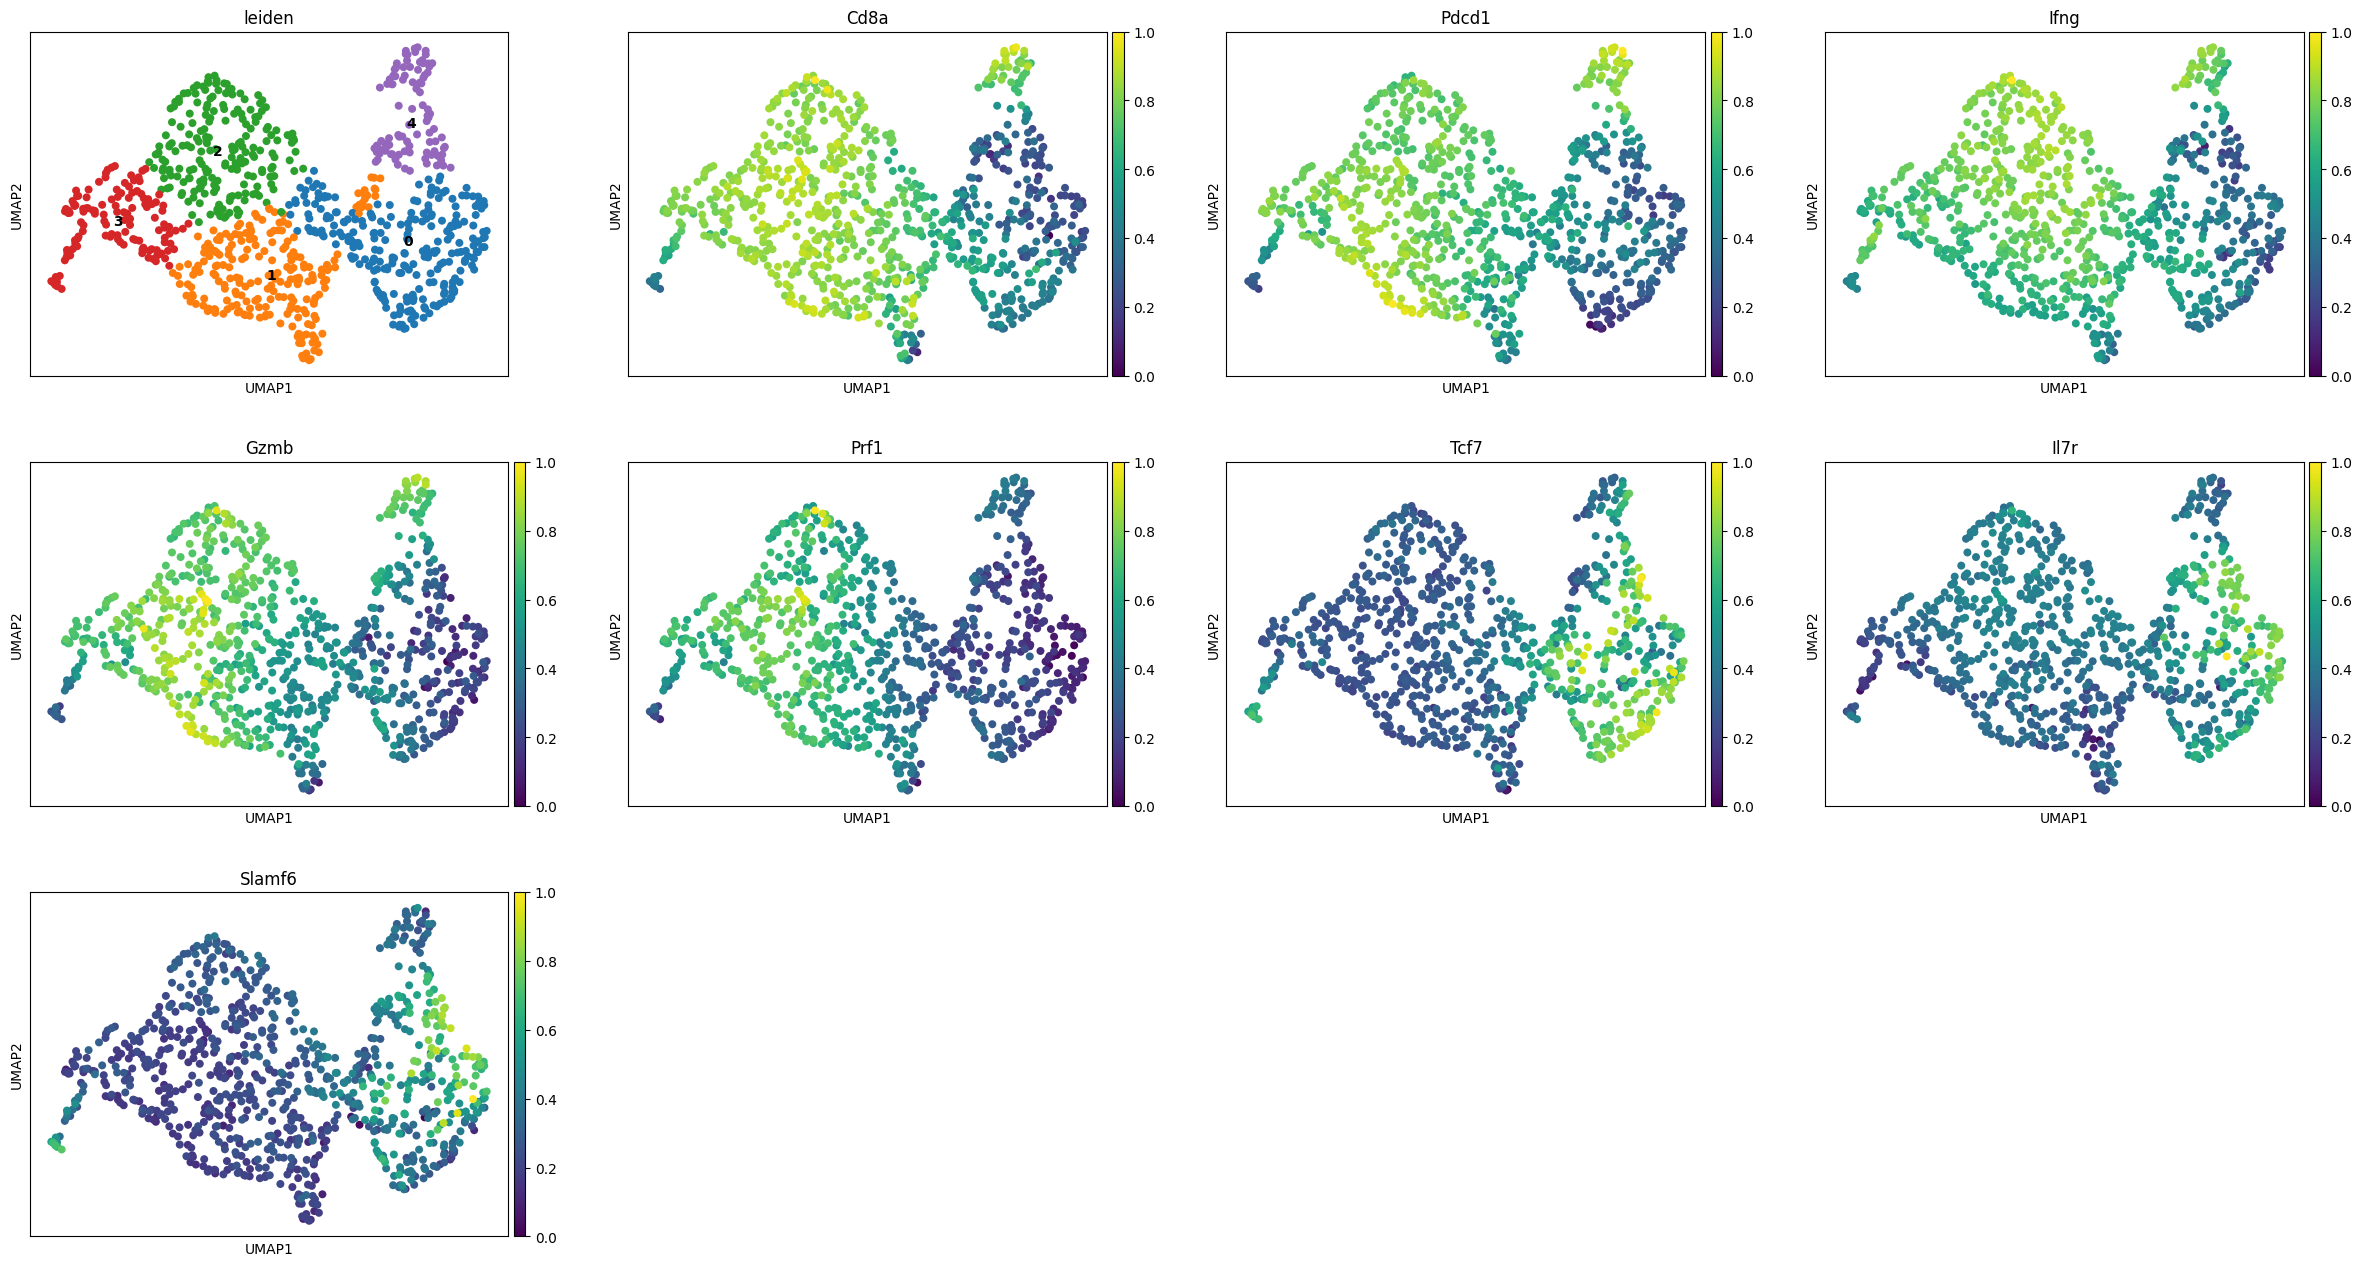

In [67]:
sc.pl.umap(recon_obj, color=["leiden","Cd8a","Pdcd1","Ifng","Gzmb","Prf1","Tcf7","Il7r","Slamf6"], show=True,legend_loc='on data')

## 🔬 CD8⁺ T Cell Cluster **Possible** Annotation in GBM Tumor Microenvironment (Based on KEGG Enrichment)

This annotation interprets CD8⁺ T cell clusters based on their enriched KEGG pathways in the GBM tumor microenvironment. Enrichment patterns are linked to known T cell states: exhausted, activated, proliferative, or tumor-reactive.

---

### 📦 Cluster `0`: **Tpex (Stem-like Exhausted Precursor CD8⁺ T Cells)**
- **Enriched KEGG Pathways**:
  - Spliceosome
  - RNA transport
  - RNA polymerase
  - Ribosome biogenesis
- **Interpretation**:
  - High transcriptional and RNA processing activity.
  - Consistent with a **Tpex** phenotype — cells with self-renewal and progenitor capacity that can give rise to terminally exhausted cells.
  - Often reside in the perivascular niche and respond to checkpoint blockade.

---

### 📦 Cluster `1`: **Terminally Exhausted / Metabolically Rewired CD8⁺ T Cells**
- **Enriched KEGG Pathways**:
  - Oxidative phosphorylation
  - Thermogenesis
  - Lysosome
  - Peroxisome
- **Interpretation**:
  - Mitochondrial pathways are heavily upregulated, suggesting a shift from glycolysis to OxPhos.
  - This is a hallmark of **terminally exhausted** CD8⁺ T cells that are metabolically stressed and functionally impaired within the tumor.

---

### 📦 Cluster `2`: **Activated / Tissue-Engaged CD8⁺ T Cells**
- **Enriched KEGG Pathways**:
  - Pathways in cancer
  - PI3K-Akt and MAPK signaling
  - Focal adhesion
  - Autophagy
  - Viral infection pathways
- **Interpretation**:
  - Strong TCR stimulation, stress adaptation (autophagy), and engagement with tumor stroma.
  - These likely represent **activated CD8⁺ T cells** infiltrating tumor tissue, experiencing chronic stimulation and stress.

---

### 📦 Cluster `3`: **Effector-Like / Biosynthetically Active CD8⁺ T Cells**
- **Enriched KEGG Pathways**:
  - Ribosome
  - Spliceosome
  - Proteasome
  - RNA transport
  - Neurodegeneration-related pathways
- **Interpretation**:
  - High translational and protein turnover activity.
  - Consistent with **effector or short-lived cytotoxic T cells** undergoing biosynthetic stress.
  - May also reflect a transitional effector population.

---

### 📦 Cluster `4`: **Tumor-Reactive / Inflammatory CD8⁺ T Cells**
- **Enriched KEGG Pathways**:
  - TNF signaling
  - MAPK signaling
  - Ubiquitin-mediated proteolysis
  - HIV/HCV/HBV infection pathways
  - Pathways in cancer

- **Interpretation**:
  - Strong inflammatory and TCR pathway activation.
  - These are likely **tumor-reactive CD8⁺ T cells**, producing IFN-γ and TNF-α, actively engaging tumor antigens.

---

### 🧩 Summary Table

| Cluster | Key KEGG Pathways | Likely Identity |
|--------:|-------------------|-----------------|
| `0` | Spliceosome, RNA transport, Ribosome biogenesis | **Tpex (precursor exhausted CD8⁺ T cells)** |
| `1` | OxPhos, Thermogenesis, Lysosome, Peroxisome | **Terminally exhausted / metabolically stressed CD8⁺ T cells** |
| `2` | PI3K-Akt, MAPK, Focal adhesion, Autophagy | **Activated / tissue-infiltrating CD8⁺ T cells** |
| `3` | Ribosome, Proteasome, RNA processing | **Effector-like / biosynthetically active CD8⁺ T cells** |
| `4` | TNF/TLR/MAPK signaling, Ubiquitination | **Tumor-reactive, inflammatory CD8⁺ T cells** |


<Figure size 1000x3000 with 0 Axes>

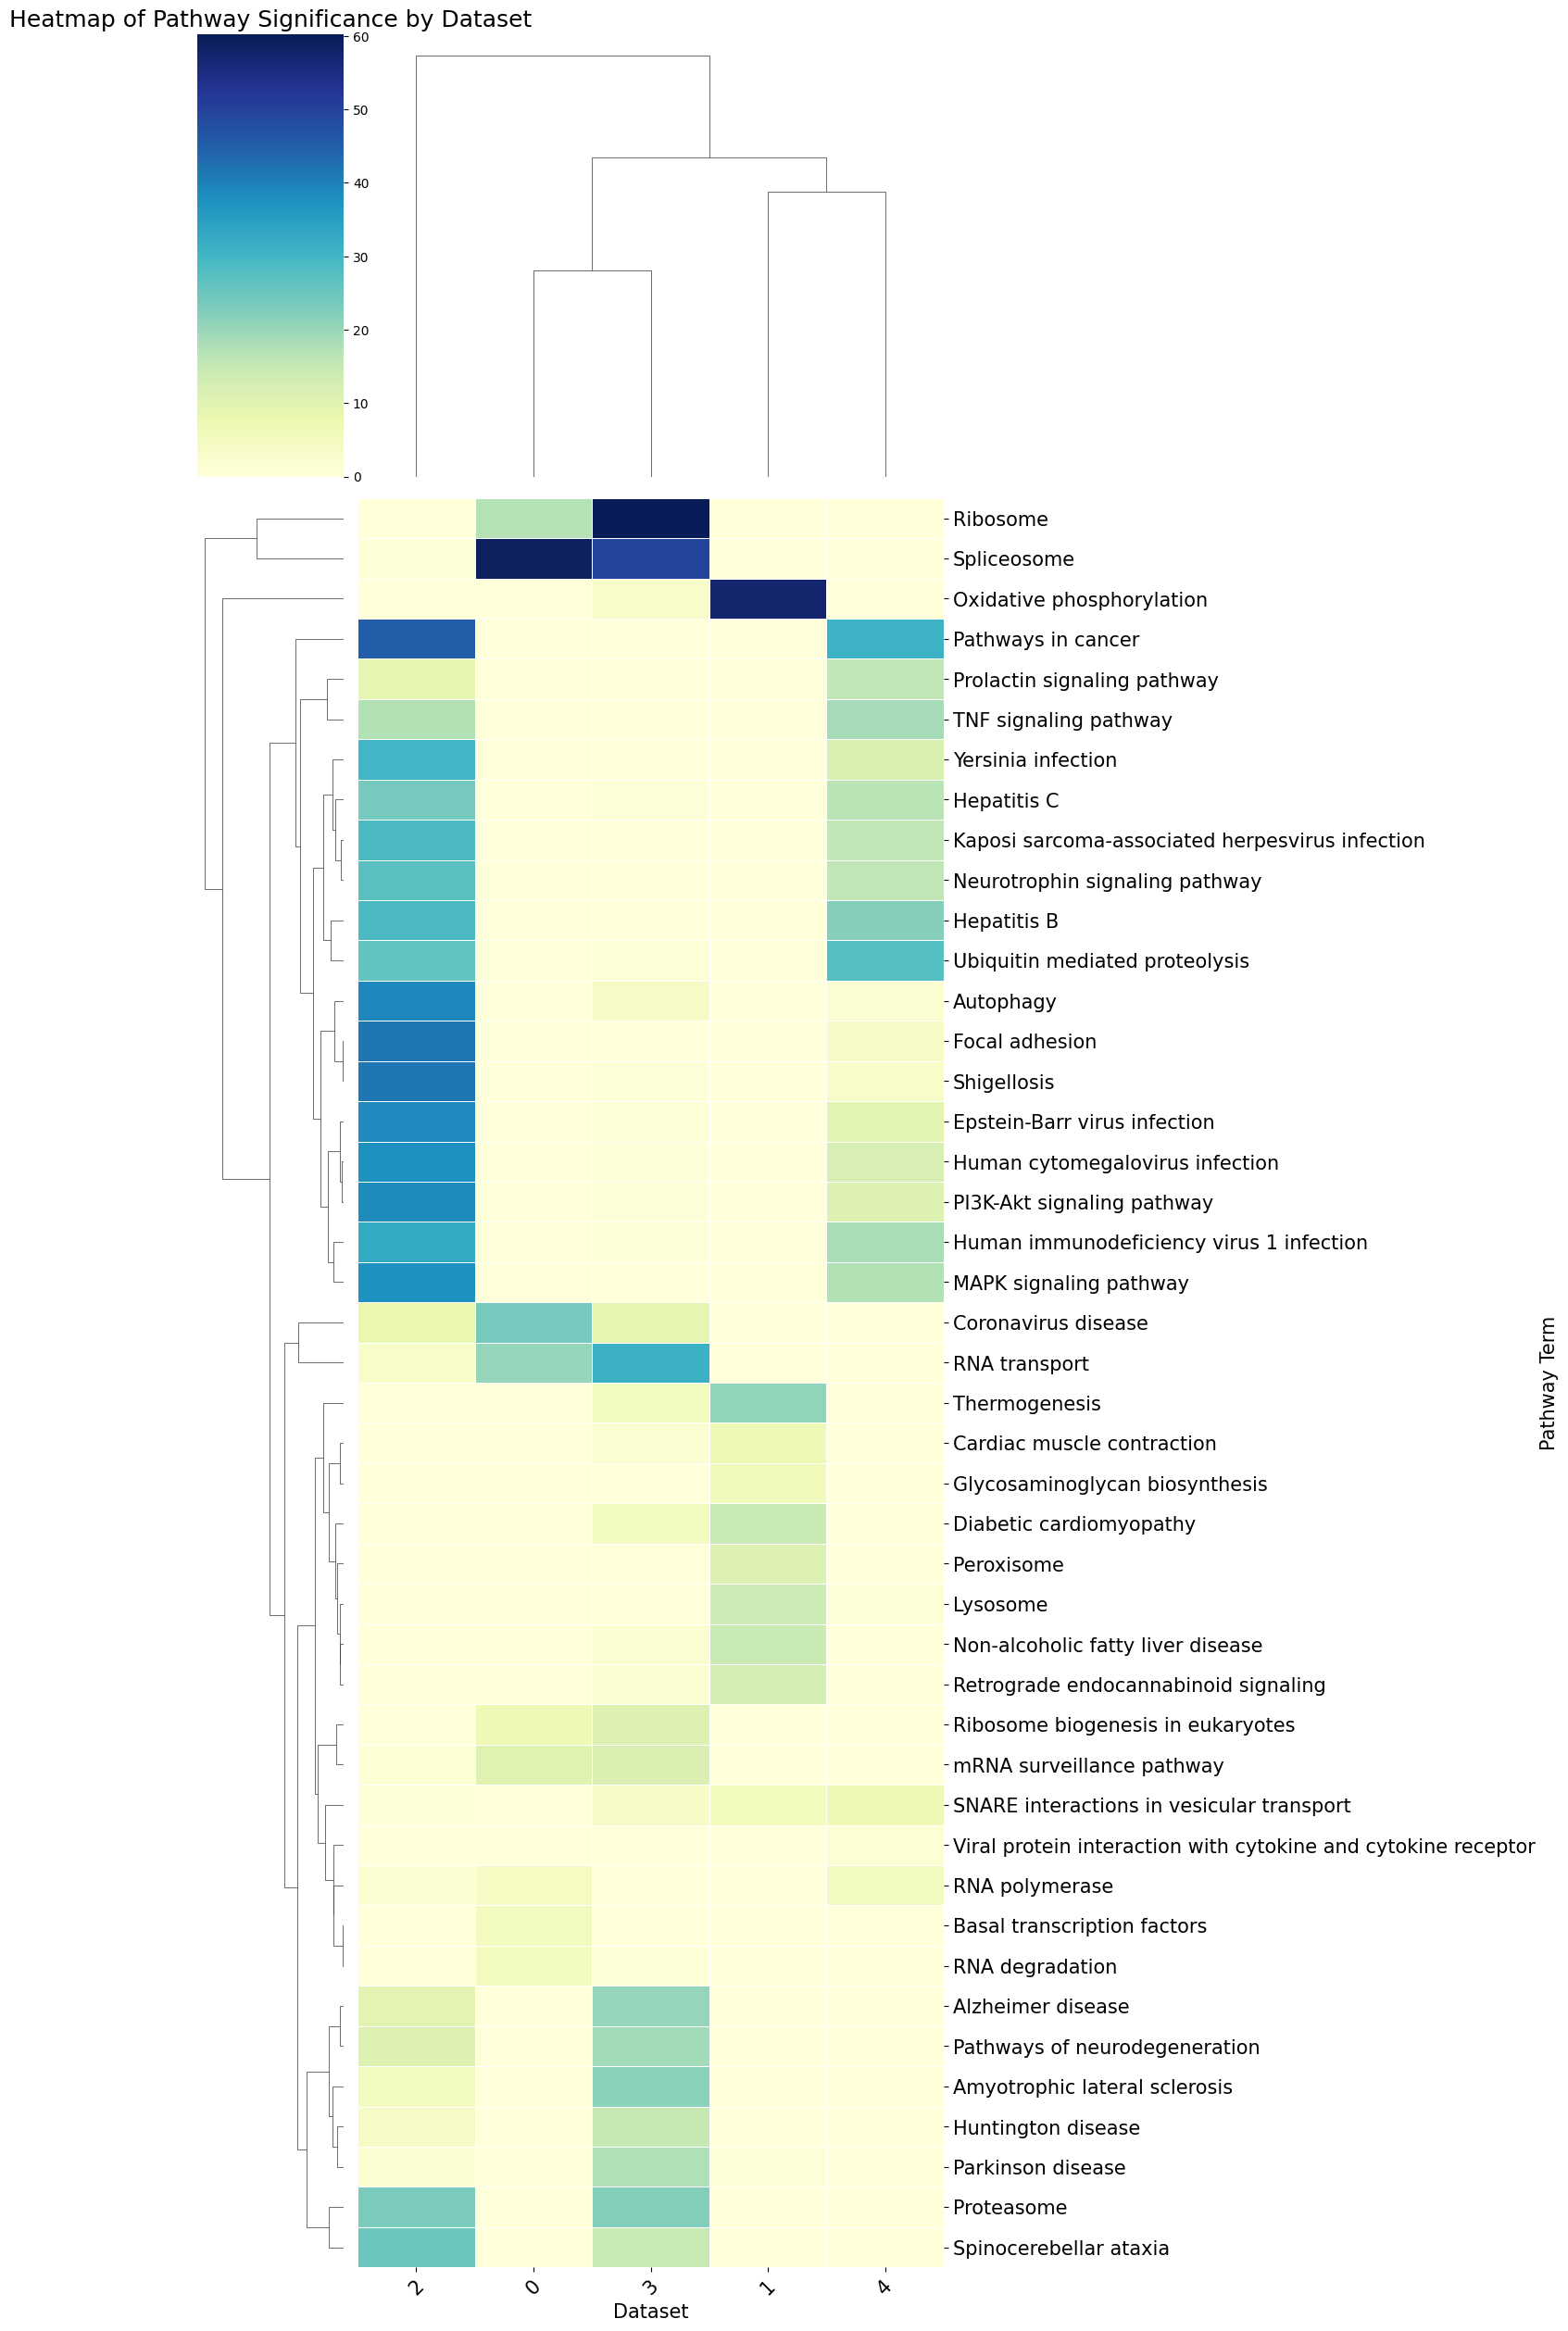

In [68]:
de_genes_per_group, significant_pathways, filtered_kegg, enrichment_results = scNET.pathway_enricment(recon_obj.copy(),groupby="leiden")

scNET.plot_de_pathways(significant_pathways,enrichment_results,10)